Margaux Bailleul 21906121
Clémence CHESNAIS 21901191

# Import des modules

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import regex as re
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem.snowball import FrenchStemmer 

In [5]:
!pip install -U spacy
!python -m spacy download fr_core_news_sm
import spacy
nlp = spacy.load('fr_core_news_sm')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 6.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


# 1. Importation des données

In [6]:
# import du fichier csv
data = pd.read_csv('french_books_reviews.csv', sep=',')
data.head()

,Unnamed: 0,book_title,author,reader_review,rating,label
0,0,Le Démon de la Colline aux Loups,Dimitri Rouchon-Borie,Ce n'est pas le premier roman à aborder les th...,5.0,1
1,1,Simple,Marie-Aude Murail,"Simple, alias Barnabé, est un jeune homme de 2...",4.0,1
2,2,La plus secrète mémoire des hommes,Mohamed Mbougar Sarr,Pour écrire La plus secrète mémoire des hommes...,4.0,1
3,3,Trancher,Amélie Cordonnier,« La violence d'Aurélien est revenue. Par la f...,3.5,0
4,4,"La guerre d'Alan, tome 2",Emmanuel Guibert,"Dans ce second album de La Guerre d’Alan, Emma...",5.0,1


Dans ce jeu de données nous disposons de 3 variables qualitatives et 2 variables quantitatives. 
Pour notre étude, nous avons le titre du livre, l'auteur, l'avis du lecteur, la note qu'il a attribué au livre ainsi qu'un label correspondant à la polarité de l'avis. Si l'avis est positif, le label vaut 1, s'il est neutre, il vaut 0 et s'il est négatif, il vaut -1.

## 1.1. Statistiques descriptives

Tout d'abord, nous commençons par regarder si la base de données contient des valeurs manquantes.

In [7]:
data["reader_review"].isna().sum()

13

13 lignes contiennent des valeurs manquantes. Nous décidons de les supprimer car elles ne représentent que 0.1% de la base de données.
De plus, nous souhaitons étudiés les avis des clients, il n'y a donc pas d'intérêt à garder les lignes où il n'y a pas d'avis.

In [8]:
data = data.dropna(subset=['reader_review'])

Nous vérifions qu'il ne reste plus de ligne sans avis.

In [9]:
data["reader_review"].isna().sum()

0

Nous regardons combien il y a d'avis pour chacune des polarités.

In [10]:
data["label"].value_counts()

polarity_distribution= (pd.DataFrame.from_dict(Counter(data.label.values),
                                             orient='index')
                                  .rename(columns={0: 'nb_reviews'}))
polarity_distribution.index.name = 'class'
polarity_distribution

,nb_reviews
class,
1,6658
0,2129
-1,858


Dans ce jeu de données, il y a 6670 positifs, 2129 neutres et 859 négatifs.

Nous calculons le pourcentage d'avis pour chaque polarité.

In [11]:
polarity_distribution['pourcentage'] = np.around(polarity_distribution.nb_reviews /
                                                np.sum(polarity_distribution.nb_reviews),
                                                2)
polarity_distribution

,nb_reviews,pourcentage
class,,
1,6658,0.69
0,2129,0.22
-1,858,0.09


Nous représentons sur un graphique la distributions des polarités selon le nombre d'avis de livre

<AxesSubplot:title={'center':"Nombre d'avis par classe"}, xlabel='class'>

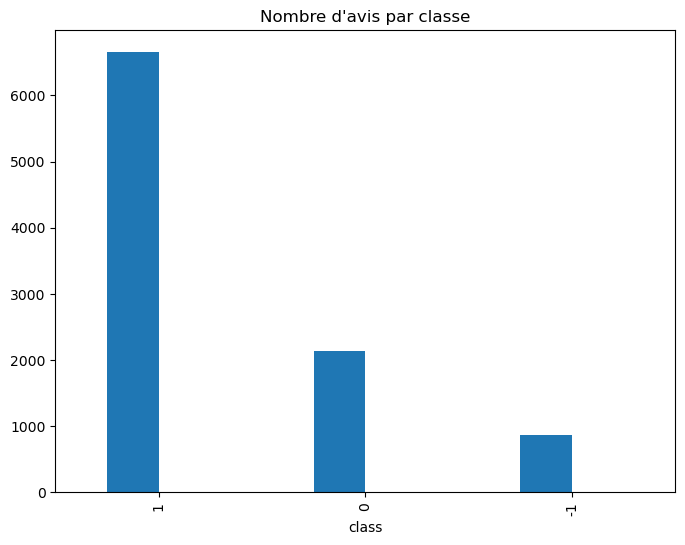

In [12]:
polarity_distribution.plot(kind='bar', figsize=(8, 6), legend=False, 
                           title="Nombre d'avis par classe")

Nous affichons les 5 premiers avis pour voir à quoi ressemble les données.


In [13]:
for i in list(data['reader_review'][0:10]):
    print(i)
    print('------------------------')

Ce n'est pas le premier roman à aborder les thèmes lourds de l'inceste et de l'enfance martyre, mais il le fait avec une audace et un brio incomparables qui rendent ce livre marquant dans une vie de lecteur. On y sent à quel point l'auteur n'a pas cherché à "faire quelque chose", on ne sent jamais l'intention, on sent juste l'urgence, incandescente, à raconter la vérité d'un homme maltraité par la vie au point de dire à la nuit «  tu ne me feras pas peur j'ai plus de noir que toi dans mon enfance ».
------------------------
Simple, alias Barnabé, est un jeune homme de 22 ans qui a l’âge mental d’un enfant de 3 ans. Kléber, son frère de 17 ans, entre en terminale au lycée, mais décide de s’occuper lui-même de son frère. Leur mère étant morte et leur père refusant de s’encombrer de sa progéniture afin de vivre pleinement sa nouvelle vie, Kléber refuse d’abandonner son frère à Malicroix, l’institution où il dépérissait. Se mettant tant bien que mal à la recherche d’un appartement pour viv

On remarque que certains avis ne sont pas réellement des avis mais un résumé du livre. Ces derniers devront être classé dans la catégorie neutre.

# 1.2. Séparation des données

Nous séparons les données en deux jeux de données : un jeu d'entrainement et un jeu de test.

In [14]:
# On mélange les lignes du DataFrame
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# On utilise la fonction train_test_split pour diviser le DataFrame
train_df, test_df = train_test_split(data, train_size=2/3, random_state=42)

# On affiche les informations sur les ensembles d'entraînement et de test
print("Taille de l'ensemble d'entraînement :", len(train_df))
print("Taille de l'ensemble de test :", len(test_df))

Taille de l'ensemble d'entraînement : 6430
Taille de l'ensemble de test : 3215


# 2. Prétraitement des données

## 2.1 Lemmatisation

Lemmatiser un texte implique de réduire chaque mot à sa forme de base ou à son "lemme".
Cela implique la suppression des variations grammaticales (comme les temps verbaux, les genres, les nombres, etc.) pour regrouper les mots qui ont la même signification de base

La lemmatisation est souvent utilisée pour améliorer la précision de l'analyse en réduisant les variations de mots à leur forme canonique. Cela aide à regrouper les mots apparentés et à réduire la complexité lors de l'analyse textuelle. 

In [15]:
def lemmatisation(text):
    text = nlp(text)
    lemmas = [token.lemma_ for token in text]
    return ' '.join(lemmas)

On applique la lemmatisation sur les avis des livres des jeux de données d'aprentissage et de test.

In [16]:
train_df['lemme'] = train_df['reader_review'].fillna('')
train_df['lemme'] = train_df['reader_review'].apply(lemmatisation)

In [17]:
for i in list(train_df['lemme'][1:5]):
    print(i)
    print('------------------------')

«    mais alors ! le père Noël exister -t il ?   » , pour - raton se demander à le lecture de ce guide qui donne envie de s’ offrir enfin à soi - même de cadeau utile ? pouvoir - être , mais ce qu’ il y avoir de certain , c’ être qu’ on y parler très peu de le mère Noël qui avoir perdre son châle .
------------------------
je retrouver avec beaucoup de joie l’ auteure , Marjane satrapi m’ avoir éblouir par son maturité dans Persépolis et je le retrouve tout aussi excellent dans Poulet à prune . on débarquer à Téhéran en 1958 , on retrouver le famille de l’ auteure dans ce opus mais pas de souci si vous n’ avoir pas lire Persépolis , c’ être un histoire inédit qu’ lui nous présente , toutefois je vous le conseil , il être magnifique .
------------------------
récit feuilletonnesque à souhait écrire par un duma jamais en manque de imagination . le aventure de Edmond Dantes être universel dans le mesure où lui pouvoir être délocaliser souher pour se inscrire dans ne importer quel pays . l

Nous faisons la même chose pour le jeu de données de test.

In [18]:
test_df['lemme'] = test_df['reader_review'].fillna('')
test_df['lemme'] = test_df['reader_review'].apply(lemmatisation)

In [19]:
for i in list(test_df['lemme'])[1:5]:
    print(i)
    print('------------------------')

et s’ il falloir choisir celui qui être sauver ?
------------------------
se attaquer à 667 page ( dense ) de ce biographie de Fouché pouvoir apparaître comme un challenge . mais le talent de historien de Emmanuel de Waresquiel avoir vite faire de donner le envie de parcourir ce ouvrage avec détermination !
------------------------
ce ouvrage plaire à petit comme à grand , à adepte de beal livre illustrer comme à sorcière et sorcier en herbe .
------------------------
livre fantastique remplir de émotion de début à le fin . le lecture de un chapitre me donner envie de connaître le suite . je avoir dévorer ce livre . par contre , quand le fin arriver , quel tristesse de laisser ce personnage . je avoir envier de continuer un petit bout de chemin avec lui .
------------------------


## 2.2. Racine des mots

Nous remplaçons les mots par leur racine. Cela permet de réduire la complexité lors de l'analyse textuelle.

In [20]:
def stem_text(text):
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    stemmer = FrenchStemmer('french')
    stems = [stemmer.stem(token) for token in tokenizer.tokenize(text)]
    return ' '.join(stems)

In [21]:
train_df['stems'] = train_df['reader_review'].apply(stem_text)

In [22]:
for i in list(train_df['stems'])[1:5]:
    print(i)
    print('------------------------')

« mais alor ! le per noël existera-t-il ? » , pour-raton se demand à la lectur de ce guid qui don envi de s ’ offrir enfin à soi-mêm des cadeau util ? peut-êtr , mais ce qu ’ il y a de certain , c ’ est qu ’ on y parl tres peu de la mer noël qui a perdu son châl .
------------------------
je retrouv avec beaucoup de joi l ’ auteur , marjan satrap m ’ avait éblou par sa matur dans persépol et je la retrouv tout auss excellent dans poulet aux prun . on débarqu à téhéran en 1958 , on retrouv la famill de l ’ auteur dans cet opus mais pas de souc si vous n ’ avez pas lu persépol , c ’ est une histoir inédit qu ’ elle nous présent , toutefois je vous le conseil , il est magnif .
------------------------
rec feuilletonnesqu à souh écrit par un dum jam en manqu d'imagin . les aventur d'edmond dant sont universel dans la mesur où elle peuvent être délocalis souh pour s'inscrir dans n'import quel pay . l'auteur parl ici d vengeanc et du droit à la justic . en se serv de sa fortun , le protagon 

Nous faisons la même chose pour le jeu de données de test.

In [23]:
test_df['stems'] = test_df['reader_review'].apply(stem_text)

In [24]:
for i in list(test_df['stems'][1:5]):
    print(i)
    print('------------------------')

et s ’ il fall chois ceux qui seraient sauv ?
------------------------
s'attaqu aux 667 pag ( dens ) de cet biograph de fouch peut apparaîtr comm un challeng . mais le talent d'historien d'emmanuel de waresquiel a vit fait de don l'env de parcour cet ouvrag avec détermin !
------------------------
cet ouvrag plair aux petit comm aux grand , aux adept de beau livr illustr comm aux sorci et sorci en herb .
------------------------
livr fantast rempl d'émot du début à la fin . la lectur d'un chapitr me don envi de connaîtr la suit . j'ai dévor ce livr . par contr , quand la fin arriv , quel tristess de laiss ces personnag . j'av envi de continu un pet bout de chemin avec eux .
------------------------


## 2.3. Etiquetage morphosyntaxique

In [25]:
def replace_words_with_pos_tag(text):
    text = nlp(text)
    return ' '.join([token.pos_ for token in text])

In [26]:
train_df['pos'] = train_df['reader_review'].apply(replace_words_with_pos_tag)

In [27]:
train_df[1:5]

,Unnamed: 0,book_title,author,reader_review,rating,label,lemme,stems,pos
3855,6198,Le guide du Noël parfait,Docteur Guido,« Mais alors ! Le père Noël existera-t-il ? »...,5.0,1,« mais alors ! le père Noël exister -t il ?...,"« mais alor ! le per noël existera-t-il ? » , ...",ADJ SPACE CCONJ ADV PUNCT DET NOUN PROPN AUX P...
2514,1844,Poulet aux prunes,Marjane Satrapi,"Je retrouve avec beaucoup de joie l’auteure, M...",4.5,1,je retrouver avec beaucoup de joie l’ auteure ...,"je retrouv avec beaucoup de joi l ’ auteur , m...",PRON VERB ADP ADV ADP VERB ADJ VERB PUNCT PROP...
5440,8277,"Le comte de Monte-Cristo, tome 1",Alexandre Dumas,Récit feuilletonnesque à souhait écrit par un ...,4.5,1,récit feuilletonnesque à souhait écrire par un...,rec feuilletonnesqu à souh écrit par un dum ja...,NOUN ADJ ADP NOUN VERB ADP DET NOUN ADV ADP NO...
2917,4924,Questions de maths sympas : Pour M. Et Mme Tou...,Hervé Lehning,C'est un livre très agréable à lire. L'auteur ...,4.0,1,ce être un livre très agréable à lire . le aut...,c'est un livr tres agréabl à lir . l'auteur ex...,PRON AUX DET NOUN ADV ADJ ADP VERB PUNCT DET N...


Nous faisons la même chose pour le jeu de données de test.

In [28]:
test_df['pos'] = test_df['reader_review'].apply(replace_words_with_pos_tag)

In [29]:
test_df[1:5]

,Unnamed: 0,book_title,author,reader_review,rating,label,lemme,stems,pos
1543,6591,La fin des temps,Jean-Louis Vincent (II),Et s’il fallait choisir ceux qui seraient sauv...,5.0,1,et s’ il falloir choisir celui qui être sauver ?,et s ’ il fall chois ceux qui seraient sauv ?,CCONJ PRON PRON VERB NOUN PRON PRON AUX VERB P...
6056,3561,Fouché : Les silences de la pieuvre,Emmanuel de Waresquiel,S'attaquer aux 667 pages (denses) de cette bio...,4.0,1,se attaquer à 667 page ( dense ) de ce biograp...,s'attaqu aux 667 pag ( dens ) de cet biograph ...,PRON VERB ADP NUM NOUN PUNCT ADJ PUNCT ADP DET...
5020,4996,Mon grand grimoire de petite sorcière,Anne-Sophie Schlick,Cet ouvrage plaira aux petits comme aux grands...,4.5,1,"ce ouvrage plaire à petit comme à grand , à ad...","cet ouvrag plair aux petit comm aux grand , au...",DET NOUN VERB ADP ADJ ADP ADP NOUN PUNCT ADP N...
4397,5319,T'embrasser sous la neige,Emily Blaine,livre fantastique rempli d'émotions du début à...,5.0,1,livre fantastique remplir de émotion de début ...,livr fantast rempl d'émot du début à la fin . ...,NOUN ADJ VERB ADP NOUN ADP NOUN ADP DET NOUN P...


Etant donné que notre fonction de lemmatisation est assez longue a exécuter, nous avons décidé de sauvegarder les jeux de données de test et d'apprentissage dans des fichiers pickle.

In [30]:
# Sauvegarde
train_df.to_pickle('train.pkl')
test_df.to_pickle('test.pkl')

## 2.4. Entités nommées

In [31]:
def ner(text):
    text = nlp(text)
    new_text = []
    for token in text:
        if token.ent_iob_ == "O":
            new_text.append(token.text)
        elif token.ent_iob_ == "B":
            new_text.append(token.ent_type_)
        # Si l'entité comprend plusieurs mot on ne répète pas l'étiquette
        else:
            continue
    return ' '.join(new_text)

Pour expliquer cette fonction, nous prenons l'exemple avec la phrase suivante :
"Elle vit à Paris et travaille chez Google. Elle a rencontré John Doe à New York."

La fontion pour chaque mot donne le résultat suivant :

- "Elle" : "O" (Outside), car ce mot ne fait pas partie d'une entité nommée.

- "vit" : "O" (Outside), pas une entité nommée.

- "à" : "O" (Outside), pas une entité nommée.

- "Paris" :"B" (Beginning) et ent_type_ = "LIEU" , car c'est le début d'une entité nommée de type "LIEU".

- "et" : "O" (Outside), pas une entité nommée.

- "travaille" : "O" (Outside), pas une entité nommée.

- "chez" : "O" (Outside), pas une entité nommée.

- "Google" : "B" (Beginning) et ent_type_ = "ORGANISATION", car c'est le début d'une entité nommée de type "ORGANISATION".

- "." : "O" (Outside), pas une entité nommée.

- "Elle" : "O" (Outside), pas une entité nommée.

- "a" : "O" (Outside), pas une entité nommée.

- "rencontré" : "O" (Outside), pas une entité nommée.

- "John" : "B" (Beginning) et ent_type_ = "PERSONNE", car c'est le début d'une entité nommée de type "PERSONNE".

- "Doe" : "I" (Inside) et ent_type_ = "PERSONNE", car c'est la suite d'une entité nommée de type "PERSONNE".

- "à" : "O" (Outside), pas une entité nommée.

- "New" : "B" (Beginning) et ent_type_ = "LIEU", car c'est le début d'une entité nommée de type "LIEU".

- "York" : "I" (Inside) et ent_type_ = "LIEU", car c'est la suite d'une entité nommée de type "LIEU".

- "." : "O" (Outside), pas une entité nommée.


Les entités de type I ne sont pas affichées.
Pour les mots de type B, ils seront remplacées par le type de l'entité nommée. Par exemple, "Paris" sera remplacé par "LIEU".

On aura donc la phrase suivante :

"Elle vit à LIEU et travaille chez ORGANISATION. Elle a rencontré PERSONNE à LIEU."

Nous appliquons cette fonction sur les jeux de données d'apprentissage et de test.

In [32]:
train_df['entites_nommees'] = train_df['reader_review'].apply(ner)

In [33]:
for i in list(train_df['entites_nommees'][1:5]):
    print(i)
    print('------------------------')

«    Mais alors ! Le père MISC existera -t -il ?   » , pour - raton se demander à la lecture de ce guide qui donne envie de PER offrir enfin à soi - même des cadeaux utiles ? Peut - être , mais ce qu’ il y a de certain , MISC est LOC on y parle très peu de la mère MISC qui a perdu son châle .
------------------------
Je retrouve avec beaucoup de joie l’ auteure , MISC PER avait ébloui par sa maturité dans LOC et je la retrouve tout aussi excellent dans LOC aux prunes . On débarque à LOC en 1958 , on retrouve la famille de LOC auteure dans cet opus mais pas de soucis si vous PER avez pas lu LOC , MISC est une histoire inédite qu’ elle nous présente , toutefois je vous le conseil , il est magnifique .
------------------------
Récit feuilletonnesque à souhait écrit par un PER jamais en manque d' imagination . Les aventures d' PER sont universelles dans la mesure où elles peuvent être délocalisées souhait pour s' inscrire dans n' importe quel pays . L' auteur parle ici d vengeance et du dr

In [34]:
test_df['entites_nommees'] = test_df['reader_review'].apply(ner)

In [35]:
for i in list(test_df['entites_nommees'][1:5]):
    print(i)
    print('------------------------')

Et LOC il fallait choisir ceux qui seraient sauvés ?
------------------------
S' attaquer aux 667 pages ( denses ) de cette biographie de PER peut apparaître comme un challenge . Mais le talent d' historien d' PER a vite fait de donner l' envie de parcourir cet ouvrage avec détermination !
------------------------
Cet ouvrage plaira aux petits comme aux grands , aux adeptes de beaux livres illustrés comme aux sorcières et sorciers en herbe .
------------------------
livre fantastique rempli d' émotions du début à la fin . la lecture d' un chapitre me donnait envie de connaître la suite . j' ai dévoré ce livre . par contre , quand la fin arrive , quelle tristesse de laisser ces personnages . j' avais envie de continuer un petit bout de chemin avec eux .
------------------------


In [36]:
# Sauvegarde
train_df.to_pickle('train.pkl')
test_df.to_pickle('test.pkl')

## 2.5. Traitement des URLS 

Nous remplaçons les URLS par un mot fictif 

In [37]:
def remplacer_url(text, url_replacement='urlexpr'):
    text = re.sub(r'https?:\S+', url_replacement, text) # http://t.co/eFKkE9W0GI
    text = re.sub(r'\bwww\.\S+', url_replacement, text) # www.example.com
    return text

In [38]:
train_df['sans_url'] = train_df['reader_review'].apply(remplacer_url)

In [39]:
for i in list(train_df["sans_url"][1:10]):
    print(i)
    print('------------------------')

«  Mais alors ! Le père Noël existera-t-il ? », pour-raton se demander à la lecture de ce guide qui donne envie de s’offrir enfin à soi-même des cadeaux utiles ? Peut-être, mais ce qu’il y a de certain, c’est qu’on y parle très peu de la mère Noël qui a perdu son châle.
------------------------
Je retrouve avec beaucoup de joie l’auteure, Marjane Satrapi m’avait ébloui par sa maturité dans Persépolis et je la retrouve tout aussi excellent dans Poulet aux prunes. On débarque à Téhéran en 1958, on retrouve la famille de l’auteure dans cet opus mais pas de soucis si vous n’avez pas lu Persépolis, c’est une histoire inédite qu’elle nous présente, toutefois je vous le conseil, il est magnifique.
------------------------
Récit feuilletonnesque à souhait écrit par un Dumas jamais en manque d'imagination. Les aventures d'Edmond Dantes sont universelles dans la mesure où elles peuvent être délocalisées souhait pour s'inscrire dans n'importe quel pays. L'auteur parle ici d vengeance et du droit 

Nous faisons la même chose pour le jeu de données de test.

In [40]:
test_df['sans_url'] = test_df['reader_review'].apply(remplacer_url)

In [41]:
for i in list(test_df["sans_url"][1:10]):
    print(i)
    print('------------------------')

Et s’il fallait choisir ceux qui seraient sauvés ?
------------------------
S'attaquer aux 667 pages (denses) de cette biographie de Fouché peut apparaître comme un challenge. Mais le talent d'historien d'Emmanuel de Waresquiel a vite fait de donner l'envie de parcourir cet ouvrage avec détermination!
------------------------
Cet ouvrage plaira aux petits comme aux grands, aux adeptes de beaux livres illustrés comme aux sorcières et sorciers en herbe.
------------------------
livre fantastique rempli d'émotions du début à la fin. la lecture d'un chapitre me donnait envie de connaître la suite. j'ai dévoré ce livre. par contre, quand la fin arrive, quelle tristesse de laisser ces personnages. j'avais envie de continuer un petit bout de chemin avec eux.
------------------------
Super roman de Noel, qui en plus se passe en Martinique du coup il fait chaud. Les personnages sont profonds et bien travailler. Il y a de la bienveillance et du consentement entre les protagonistes, qui est clair

In [42]:
train_df.shape, test_df.shape

((6430, 11), (3215, 11))

In [43]:
# Sauvegarde
train_df.to_pickle('train.pkl')
test_df.to_pickle('test.pkl')

## 2.6 Suppression de certains mots

In [44]:
train_df = pd.read_pickle('train.pkl')
test_df = pd.read_pickle('test.pkl')

La suppression de certains mots comme les "mots vides", c'est-à-dire les mots qui n'apportent pas d'information pour la classification, permettent de se focaliser sur les mots les plus importants. Par exemple, les mots "et", "car", "le", "la"... n'apportent pas d'information. 
De plus, les modèles d'analyse de sentiments peuvent être sensibles à la dimensionnalité élevée des données. 

En réduisant le vocabulaire, on réduit le nombre de mots que le modèle doit prendre en compte, ce qui peut améliorer l'efficacité de l'apprentissage et la vitesse d'entraînement.
Certains mots peuvent apparaître rarement ou être spécifiques à des documents particuliers, ce qui peut introduire du bruit dans le modèle. 
Par ailleurs, en se concentrant sur les termes les plus fréquents et les plus informatifs, le modèle peut se généraliser plus efficacement à de nouveaux textes. Cela peut également contribuer à éviter le surajustement aux données d'entraînement.


In [45]:
sw = nltk.corpus.stopwords.words('french')
print(sw)

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

Nous appliquerons ce corpus de mots vides à nos jeux de données d'apprentissage et de test dans la suite de notre étude.

# 3. Calcul des valeurs des descripteurs

## 3.1. Séparation du jeu de données d'entrainement en 2 jeux de données

Nous séparons le jeu de données d'entrainement en 2 jeux de données : un jeu de données d'entrainement et un jeu de données de validation. 

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df['reader_review'],
                                                      train_df['label'],
                                                      train_size=0.75,
                                                      random_state=5)

In [48]:
X_train.shape, X_valid.shape

((4822,), (1608,))

In [49]:
y_train.shape, y_valid.shape

((4822,), (1608,))

In [50]:
y_train

1871    1
7654   -1
1863   -1
4761    1
6294    0
       ..
2606    1
5466    1
3191    1
7438    1
5113    1
Name: label, Length: 4822, dtype: int64

Pour le jeu de données tests, on met la variable label dans un objet "y_test" et la colonne "reader_review" dans un objet "X_test".

In [51]:
X_test, y_test = test_df['reader_review'], test_df['label']

## 3.2. Présence ou absence de certains mots : binaire

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

In [53]:
bin_count = CountVectorizer(binary=True, stop_words=sw, strip_accents='unicode')

In [54]:
bin_count.fit(X_train)
bin_count

/Users/margauxbailleul/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['etaient', 'etais', 'etait', 'etant', 'etante', 'etantes', 'etants', 'ete', 'etee', 'etees', 'etes', 'etiez', 'etions', 'eumes', 'eutes', 'fumes', 'futes', 'meme'] not in stop_words.
  warnings.warn(


CountVectorizer(binary=True,
                stop_words=['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de',
                            'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils',
                            'je', 'la', 'le', 'les', 'leur', 'lui', 'ma',
                            'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne',
                            'nos', ...],
                strip_accents='unicode')

In [55]:
X_train_vectorized_bin = bin_count.transform(X_train)
X_train_vectorized_bin

<4822x22488 sparse matrix of type '<class 'numpy.int64'>'
	with 132878 stored elements in Compressed Sparse Row format>

In [56]:
X_valid_vectorized_bin = bin_count.transform(X_valid)
X_test_vectorized_bin = bin_count.transform(X_test)

In [57]:
X_valid_vectorized_bin

<1608x22488 sparse matrix of type '<class 'numpy.int64'>'
	with 39733 stored elements in Compressed Sparse Row format>

# ATTENTION !!! ON EN FAIT QUOI DE ÇA ?

## 3.3 Numérique discret : décompte d'occurences

La fonction CountVectorizer permet de compter le nombre d'occurences de chaque mot dans chaque avis. Elle transforme une liste de textes en une représentation numérique utilisable pour des algorithmes d'apprentissage automatique.

Le processus de fit consiste à analyser le texte pour déterminer les mots uniques présents dans X_train et à créer une représentation vectorielle de ces mots. Chaque texte sera représenté comme un vecteur où chaque élément correspond à la fréquence d'apparition de chaque mot du vocabulaire dans ce texte.

Ainsi, cela créé un objet "CountVectorizer" qui contient le vocabulaire de tous les mots de tous les avis.\ Cet objet est appelé "vect_count".

In [58]:
vect_count = CountVectorizer().fit(X_train)

On affiche les 50 premiers noms des mots utilisés pour créer la représentation vectorielle des textes :

In [59]:
vect_count.get_feature_names_out()[:50]

array(['000', '02', '03', '08', '10', '100', '1000', '1078', '109', '11',
       '112', '115', '12', '1200', '121', '125', '12ans', '12heures',
       '13', '130', '130kg', '130p', '14', '140', '141', '1415', '1425',
       '144', '14ans', '15', '150', '1518', '153', '15jours', '16', '160',
       '1600', '1604', '1613', '1615', '164', '165', '1664', '1665',
       '1691', '16ème', '17', '173', '1750', '1756'], dtype=object)

On affiche les 50 derniers noms des mots utilisés pour créer la représentation vectorielle des textes :

In [60]:
vect_count.get_feature_names_out()[-50:]

array(['évoquée', 'évoquées', 'évoqués', 'évènement', 'évènementielle',
       'évènements', 'événement', 'événements', 'êkho', 'êtes', 'être',
       'êtres', 'île', 'îles', 'ïnes', 'ôshi', 'ôte', 'örn', 'œdipe',
       'œdipienne', 'œil', 'œils', 'œuf', 'œufs', 'œuvre', 'œuvrent',
       'œuvres', 'œuvré', 'достоевский', 'михайлович', 'фёдор', '日光流年',
       '阎连科', '𝐻𝑒𝑎𝑟𝑡𝑠', '𝐽𝑒', '𝑁𝑜𝑒', '𝑇𝑎𝑖𝑛𝑡𝑒𝑑', '𝑎𝑖𝑚𝑒𝑟', '𝑓𝑒𝑟𝑎𝑖𝑠', '𝑡𝑒',
       '𝗟𝗮', '𝗰𝗵𝗼𝘀𝗲', '𝗱𝗶𝘀𝗽𝗼𝘀𝗲𝘀', '𝗲𝗻', '𝗲𝘁', '𝗽𝗿𝗼𝗽𝗼𝘀𝗲', '𝗾𝘂𝗲𝗹𝗾𝘂𝗲', '𝘁𝗲',
       '𝘁𝘂', '𝘃𝗶𝗲'], dtype=object)

In [61]:
len(vect_count.get_feature_names_out())

23492

Ainsi, nous créons une représentation vectorielle des données d'entraînement en se basant sur le vocabulaire établi précédemment. 

Donc, cette opération convertit les données textuelles en une matrice numérique où chaque ligne correspond à un texte et chaque colonne correspond à la fréquence d'un mot spécifique dans ce texte.

In [62]:
X_train_vectorized_count = vect_count.transform(X_train)
X_train_vectorized_count

<4822x23492 sparse matrix of type '<class 'numpy.int64'>'
	with 192491 stored elements in Compressed Sparse Row format>

X_train_count est une matrice de taille (n_train=4822, n_features=23492) où n_train est le nombre de textes dans le jeu de données d'entraînement et n_features est le nombre de mots dans le vocabulaire.

Nous faisons la même chose pour le jeu de données de validation et de test :

In [63]:
X_valid_vectorized_count = vect_count.transform(X_valid)
X_test_vectorized_count = vect_count.transform(X_test)

Nous créons un autre objet CountVectorizer mais cette fois-ci, nous posons certaines conditions : le mot doit apparaitre au moins 5 fois dans les documents pour être inclus dans le vocabulaie. De plus, les mots seront des unigrammes et des bigrammes.

In [64]:
vect_count_bigrams = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(X_train)
X_train_vectorized_count_bigrams = vect_count_bigrams.transform(X_train)
X_valid_vectorized_count_bigrams = vect_count_bigrams.transform(X_valid)
X_test_vectorized_count_bigrams = vect_count_bigrams.transform(X_test)

In [65]:
len(vect_count_bigrams.get_feature_names_out())

10483

Le nombre de mots dans le vocabulaire a diminué du fait des conditions ajoutées dans le CountVectorizer.

## 3.4 Numérique continu : TF-IDF

Nous avons décidé de créer 2 objets tfidfVectorizer : un avec les stopwords et un sans les stopwords. En effet, les mots entrés dans les stopwords peuvent être importants pour interpréter la polarité d'un avis. 

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

### 3.4.1 Avec stopwords

In [67]:
vect_tfidf_sw = TfidfVectorizer(min_df=5, stop_words=sw, ngram_range=(1,2)).fit(X_train)

In [68]:
len(vect_count.get_feature_names_out()), len(vect_tfidf_sw.get_feature_names_out())

(23492, 5507)

In [69]:
X_train_vectorized_tfidf_sw = vect_tfidf_sw.transform(X_train)
X_valid_vectorized_tfidf_sw = vect_tfidf_sw.transform(X_valid)
X_test_vectorized_tfidf_sw = vect_tfidf_sw.transform(X_test)

### 3.4.2 Sans stopwords

In [70]:
vect_tfidf = TfidfVectorizer(min_df=5).fit(X_train)

In [71]:
len(vect_count.get_feature_names_out()), len(vect_tfidf.get_feature_names_out())

(23492, 4336)

In [72]:
X_train_vectorized_tfidf = vect_tfidf.transform(X_train)
X_valid_vectorized_tfidf = vect_tfidf.transform(X_valid)
X_test_vectorized_tfidf = vect_tfidf.transform(X_test)

# 4. Classification sans les stopwords 

In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

## 4.1. Modèles de référence faibles (*weak baselines*)

### 4.1.1. Choix alétaoire

In [74]:
from sklearn.dummy import DummyClassifier

In [75]:
random_prop_class = DummyClassifier(strategy='stratified').fit(X_train_vectorized_tfidf,
                                                               y_train)
predictions_valid = random_prop_class.predict(X_valid_vectorized_tfidf)
conf_mat = confusion_matrix(y_valid, predictions_valid)

In [76]:
print(conf_mat)

[[ 12  30  77]
 [ 38  76 228]
 [ 90 252 805]]


In [77]:
accuracy_score(y_valid, predictions_valid)

0.5553482587064676

In [78]:
random_uniform = DummyClassifier(strategy='uniform').fit(X_train_vectorized_tfidf,
                                                         y_train)
predictions_valid = random_uniform.predict(X_valid_vectorized_tfidf)
predictions_valid

array([ 1, -1,  1, ...,  0,  0,  0])

In [79]:
conf_mat = confusion_matrix(y_valid, predictions_valid)

In [80]:
print(conf_mat)

[[ 39  34  46]
 [115 107 120]
 [400 372 375]]


In [81]:
accuracy_score(y_valid, predictions_valid)

0.3240049751243781

In [82]:
print(classification_report(y_valid, predictions_valid))

              precision    recall  f1-score   support

          -1       0.07      0.33      0.12       119
           0       0.21      0.31      0.25       342
           1       0.69      0.33      0.44      1147

    accuracy                           0.32      1608
   macro avg       0.32      0.32      0.27      1608
weighted avg       0.54      0.32      0.38      1608



### 4.1.2. Prédiction constante de la classe majoritaire

In [83]:
polarity_distribution

,nb_reviews,pourcentage
class,,
1,6658,0.69
0,2129,0.22
-1,858,0.09


### Conclusion modèles de référence faibles
Ici, l'accuray des modèles n'est vraiment pas très bonne.

## 4.2. Classifieur bayésien naïf

In [84]:
from sklearn.naive_bayes import MultinomialNB

In [85]:
model_nb = MultinomialNB().fit(X_train_vectorized_tfidf, y_train)
predictions_valid = model_nb.predict(X_valid_vectorized_tfidf)

In [86]:
accuracy_score(y_valid, predictions_valid)

0.7139303482587065

Le modèle prédit correctement 71.33% des avis du jeu de données de validation.

On affiche la matrice de confusion pour le jeu de données de validation :

In [87]:
print(classification_report(y_valid, predictions_valid))

              precision    recall  f1-score   support

          -1       1.00      0.01      0.02       119
           0       0.00      0.00      0.00       342
           1       0.71      1.00      0.83      1147

    accuracy                           0.71      1608
   macro avg       0.57      0.34      0.28      1608
weighted avg       0.58      0.71      0.60      1608



/Users/margauxbailleul/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/margauxbailleul/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/margauxbailleul/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

## 4.3. Régression logistique

### 4.3.1. Premier modèle de régression logistique 

In [88]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model_lr = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                              max_iter=200).fit(X_train_vectorized_count, y_train)

: 

In [ ]:
predictions_valid = model_lr.predict(X_valid_vectorized_count)

In [ ]:
accuracy_score(y_valid, predictions_valid)

0.6716417910447762

Notre modèle de régression logistique prédit correctement 67.16% des avis du jeu de données de validation.

On affiche la matrice de confusion pour le jeu de données de validation :

In [ ]:
print(classification_report(y_valid, predictions_valid))

              precision    recall  f1-score   support

          -1       0.26      0.12      0.16       119
           0       0.29      0.18      0.22       342
           1       0.75      0.88      0.81      1147

    accuracy                           0.67      1608
   macro avg       0.43      0.39      0.40      1608
weighted avg       0.61      0.67      0.63      1608



### Association des mots avec les classes

In [ ]:
def print_n_strongly_associated_features(vectoriser, model, n):
    feature_names = np.array(vectoriser.get_feature_names_out())

    for i in range(3):
        class_name = model.classes_[i]
        print("CLASSE {}".format(class_name))
        idx_coefs_sorted = model.coef_[i].argsort() # ordre croissant
        print("Les dix variables ayant l'association négative la plus forte " + 
              "avec la classe {} :\n{}\n".format(class_name,
                                                 feature_names[idx_coefs_sorted[:n]]))
        idx_coefs_sorted = idx_coefs_sorted[::-1] # ordre décroissant
        print("Les dix variables ayant l'association positive la plus forte " +
              "avec la classe {} :\n{}\n"
              .format(class_name,
                      feature_names[idx_coefs_sorted[:n]]))
        print()

In [ ]:
print_n_strongly_associated_features(vect_count, model_lr, 10)

CLASSE -1
Les dix variables ayant l'association négative la plus forte avec la classe -1 :
['avoue' 'vous' 'coeur' 'toute' 'peux' 'laisse' 'adoré' 'originale'
 'aventure' 'quel']

Les dix variables ayant l'association positive la plus forte avec la classe -1 :
['déception' 'bof' 'prénoms' 'malheureusement' 'opération' 'melancholia'
 'pffff' 'abandon' 'vaincus' 'voulu']


CLASSE 0
Les dix variables ayant l'association négative la plus forte avec la classe 0 :
['collection' 'poésie' 'tellement' 'écrire' 'agit' 'excellent' 'héroïne'
 'couleur' 'sera' 'couverture']

Les dix variables ayant l'association positive la plus forte avec la classe 0 :
['douce' 'tragédie' 'sympathique' 'direction' 'voulait' 'épouse' 'belge'
 'choisit' 'points' 'initiatique']


CLASSE 1
Les dix variables ayant l'association négative la plus forte avec la classe 1 :
['déception' 'loup' 'déçue' 'douce' 'adhéré' 'netgalleyfrance' 'trouvé'
 'points' 'soient' 'tomes']

Les dix variables ayant l'association positive la p

On peut voir qu'il y a le mot "deçue" dans la classe 1 mais cela dépend du contexte. L'avis a pu être "je ne suis pas du tout déçue" et donc la polarité est positive.

Nous pouvons voir quel le résultat est très logique. En effet, si nous prenons l'exemple de la classe 1, nous pouvons voir que les mots les moins probables d'y être associés sont par exemple "déception" ou "déçue", tandis qu eles mots étant le plus probable d'être cités sont "magnifique" ou encore "excellent". 

### 4.3.2. Deuxième modèle de régression logistique

In [ ]:
model_lr = LogisticRegression(multi_class='multinomial',
                              solver='lbfgs').fit(X_train_vectorized_tfidf, y_train)
predictions_valid = model_lr.predict(X_valid_vectorized_tfidf)

In [ ]:
accuracy_score(y_valid, predictions_valid)

0.7120646766169154

La performance est meilleure que le premier modèle de régression logistique. En effet, le modèle prédit correctement 71.21% des avis du jeu de données de validation.

In [ ]:
print(classification_report(y_valid, predictions_valid))

              precision    recall  f1-score   support

          -1       0.60      0.03      0.05       119
           0       0.37      0.05      0.09       342
           1       0.72      0.98      0.83      1147

    accuracy                           0.71      1608
   macro avg       0.56      0.35      0.32      1608
weighted avg       0.64      0.71      0.62      1608



In [ ]:
feature_names = np.array(vect_tfidf.get_feature_names_out())
idx_tfidf_sorted = X_train_vectorized_tfidf.max(0).toarray()[0].argsort()
# print("TF-IDF le moins élevé : {}".format(feature_names[idx_tfidf_sorted[:10]]))
# print("TF-IDF le plus élevé : {}".format(feature_names[idx_tfidf_sorted[:-11:-1]]))

IndexError: index 5251 is out of bounds for axis 0 with size 4336

### 4.3.3. Troisième modèle de régression logistique

Nous créons un modèle de régression logistique avec le vectoriseur à unigrammes et bigrammes.

In [ ]:
model_lr = LogisticRegression(multi_class='multinomial', 
                              solver='lbfgs',
                              max_iter=500).fit(X_train_vectorized_count_bigrams, 
                                                y_train)
predictions_valid = model_lr.predict(X_valid_vectorized_count_bigrams)

In [ ]:
accuracy_score(y_valid, predictions_valid)

0.6741293532338308

Ce modèle prédit correctement 67.41% des avis du jeu de données de validation.\
Sa performance est moins bonne que le deuxième modèle de régression logistique.

In [ ]:
print(classification_report(y_valid, predictions_valid))

              precision    recall  f1-score   support

          -1       0.28      0.13      0.17       119
           0       0.35      0.25      0.29       342
           1       0.75      0.86      0.80      1147

    accuracy                           0.67      1608
   macro avg       0.46      0.41      0.42      1608
weighted avg       0.63      0.67      0.65      1608



In [ ]:
print_n_strongly_associated_features(vect_count_bigrams, model_lr, 10)

CLASSE -1
Les dix variables ayant l'association négative la plus forte avec la classe -1 :
['vous' 'et bien' 'aventure' 'avoue' 'toute' 'pour ce' 'originale'
 'ce service' 'si je' 'coeur']

Les dix variables ayant l'association positive la plus forte avec la classe -1 :
['déception' 'tomes' 'jolies' 'opération' 'prénoms' 'garou' 'éviter'
 'mauvais' 'pauvre' 'moyen']


CLASSE 0
Les dix variables ayant l'association négative la plus forte avec la classe 0 :
['sa vie' 'après avoir' 'une enquête' 'on se' 'avec une' 'sera' 'héroïne'
 'qui lui' 'tellement' 'tout en']

Les dix variables ayant l'association positive la plus forte avec la classe 0 :
['douce' 'tragédie' 'sympathique' 'et qu' 'tout un' 'et bien' 'contient'
 'en premier' 'voulait' 'racontant']


CLASSE 1
Les dix variables ayant l'association négative la plus forte avec la classe 1 :
['déception' 'tomes' 'et qu' 'douce' 'tragédie' 'loup' 'sans plus'
 'présente' 'déçue' 'points']

Les dix variables ayant l'association positive la pl

Il y a plus d'erreur dans ce modèle. 

## 4.4 SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
model_svm = SVC(kernel='linear', 
                C=0.1).fit(X_train_vectorized_count_bigrams, 
                           y_train)

predictions_valid = model_svm.predict(X_valid_vectorized_count_bigrams)

In [ ]:
accuracy_score(y_valid, predictions_valid)

0.6735074626865671

In [ ]:
print(classification_report(y_valid, predictions_valid))

              precision    recall  f1-score   support

          -1       0.21      0.13      0.16       119
           0       0.32      0.15      0.21       342
           1       0.74      0.88      0.81      1147

    accuracy                           0.67      1608
   macro avg       0.42      0.39      0.39      1608
weighted avg       0.61      0.67      0.63      1608



# 5. Classification avec les stopwords

Ici, nous n'allons pas reproduire tous les tests de modèles essayés précdemment. Nous allons simplement tester les 2 modèles avec la meilleure accuracy obtenue, pour voir si le fait de supprimer les stopwords a un impact sur notre modèle. \
Nous allons donc utiliser le deuxième modèle de régression logistique ainsi que celui avec le classifieur baïésien naïf, dont les deux accuracy sont à 71% environ.

## 5.1 Classifieur naïf baïésien

In [ ]:
model_nb = MultinomialNB().fit(X_train_vectorized_tfidf_sw, y_train)
predictions_valid = model_nb.predict(X_valid_vectorized_tfidf_sw)

In [ ]:
accuracy_score(y_valid, predictions_valid)

### Conclure pour ici mais j'ai pas les scores

## 5.2 Deuxième modèle de régression logistique

In [ ]:
model_lr = LogisticRegression(multi_class='multinomial',
                              solver='lbfgs').fit(X_train_vectorized_tfidf_sw, y_train)
predictions_valid = model_lr.predict(X_valid_vectorized_tfidf_sw)

In [ ]:
accuracy_score(y_valid, predictions_valid)

### Conclure ici mais pareil j'ai pas les scores

### Est-ce qu'on fait un test en + avec bigram et trigram ? 

À VOIR :

- est ce qu'on fait aussi les tests avec les bigrams et tigrams (diminution du nb de mots) ? 
- est-ce qu'on prend reader_review pour les train et les test ou est-ce qu'on prend la colonne des entités nommées ? ou une autre colonne ? 

# 6. Conclusion

Nous pouvons donc dire que le meilleur modèle est celui avec/sans les stopwords et celui qui utilise ??? (mettre meilleur modèle)

Cependant, notre matrice de confusion est possiblement biaisée. En effet, certains de nos avis sont des "résumés" des livres, et ils on été classés dans la base de donnée comme non neutres. 

On a testé avec les bigram et trigram car intéressant dans notre cas 

On a pris la colonne avec les entités nommées car cela ne nous apporte rien de savoir le nom ??

Si on teste avec une autre colonne : expliquer pourquoi 